In [21]:
import numpy as np
import pylab as pl
import matplotlib.gridspec as gridspec
from glob import glob
import tensorflow as tf
import numpy.ma as ma
%matplotlib inline

#train1 = glob('data/Tc/01/??/Tc.016???.npy')
#train2 = glob('data/Tc2/01/??/TcS2.1.016???.npy')
#train3 = glob('data/surface/01/??/surfaceTypeIndex.016???.npy')
#label2 = glob('data/heightstorm/01/??/heightStormTop.1.016???.npy') 

baseDir= '/mnt/j/PMM/MATCH.GMI.V05A'
train1 = glob(baseDir + '/S1.ABp103-117.GMI.Tc/2017/01/??/Tc.016???.npy')
train2 = glob(baseDir + '/S1.ABp103-117.GMI.TcS2/2017/01/??/TcS2.1.016???.npy')
train3 = glob(baseDir + '/S1.ABp103-117.GMI.surfaceTypeIndex/2017/01/??/surfaceTypeIndex.016???.npy')
label2 = glob(baseDir + '/S1.ABp103-117.Ku.V06A.heightStormTop/2017/01/??/heightStormTop.1.016???.npy') 
#label2 = glob(baseDir + '/S1.ABp103-117.Ku.V06A.9ave.heightStormTop/2017/01/??/heightStormTop.016???.npy') 
latitude = glob(baseDir + '/S1.ABp103-117.GMI.Latitude/2017/01/??/Latitude.016???.npy')

#train1   = np.concatenate([np.load(i) for i in train1])
#train2   = np.concatenate([np.load(i) for i in train2])
#train3   = np.concatenate([np.load(i) for i in train3]) # set = {1,2,3,4,5, ... , 14}
#label2   = np.concatenate([np.load(i) for i in label2]) 
print 'num-files=',len(train1)
print train1[0]
print train1[-1]
train1.sort()
train2.sort()
train3.sort()
label2.sort()
latitude.sort()

nostorm = 20
#nostorm = 0
samplerate = 0.5
if nostorm >=10:
    a1idx  = np.random.choice(range(len(train1)), int(len(train1)*samplerate))
    train1 = [train1[i] for i in a1idx]
    train2 = [train2[i] for i in a1idx]
    train3 = [train3[i] for i in a1idx]
    label2 = [label2[i] for i in a1idx]
    latitude=[latitude[i] for i in a1idx]
    
train1   = np.concatenate([np.load(i) for i in train1[:]])
train2   = np.concatenate([np.load(i) for i in train2[:]])
train3   = np.concatenate([np.load(i) for i in train3[:]]) # set = {1,2,3,4,5, ... , 14}
label2   = np.concatenate([np.load(i) for i in label2[:]]) 
latitude = np.concatenate([np.load(i) for i in latitude[:]])

N = len(train1)

print(train1.shape, train2.shape, train3.shape, label2.shape)

num-files= 482
/mnt/j/PMM/MATCH.GMI.V05A/S1.ABp103-117.GMI.Tc/2017/01/01/Tc.016155.npy
/mnt/j/PMM/MATCH.GMI.V05A/S1.ABp103-117.GMI.Tc/2017/01/31/Tc.016636.npy
((713850, 15, 9), (713850, 15, 4), (713850, 15), (713850, 15))


In [22]:
train3 = train3.reshape(N,15,1)  
train_total = np.concatenate([train1,train2,train3],axis=2)
label = label2
print(train_total.shape, label.shape)

((713850, 15, 14), (713850, 15))


In [23]:
latmin = -90
latmax = 20
index_remove = []
for i in range(len(train3)):
    lat = latitude[i,8]
    if (lat>latmax)or(lat<latmin):
        index_remove.append(i)

train_total = np.delete(train_total, index_remove, axis=0)
label       = np.delete(label, index_remove, axis=0)
N = len(train_total)
print(len(index_remove) )
print(train_total.shape, label.shape)


269502
((444348, 15, 14), (444348, 15))


In [24]:
Shape    = [3, 7]
trainbox = []
surface  = []
labelbox = []
row_mid  = int((Shape[0]-1)/2)
col_mid  = int((Shape[1]-1)/2)
k0 = 0  # test
k1 = 0  # test
for i in range(N-Shape[0]+1): 
    for j in range(15-Shape[1]+1):   # range(9)
        k0 = k0+15555
        if (label[i+row_mid, j+col_mid] <= 0):continue  
        #if (label[i:i+Shape[0], j:j+Shape[1]].flatten() <= 0).sum() == 0:   
        #if (label[i:i+Shape[0], j:j+Shape[1]].flatten() <= 0).sum() <=7:  
        #if (label[i:i+Shape[0], j:j+Shape[1]].flatten() <= 0).sum() <=15: 
        if (label[i:i+Shape[0], j:j+Shape[1]].flatten() <= 0).sum() <=nostorm: 
            k1=k1+1 
            trainbox.append(train_total[i:i+Shape[0], j:j+Shape[1], :-1])
            surface.append( train_total[i+row_mid   , j+col_mid   ,  -1])
            labelbox.append(label[i+row_mid, j+col_mid])
print(len(trainbox), len(labelbox), len(surface), trainbox[0].shape, surface[0], labelbox[0])
print k0,k1, (N-Shape[0]+1)*(15-Shape[1]+1)

(235401, 235401, 235401, (3, 7, 13), 1.0, 2866.9934)
62206218270 235401 3999114


In [25]:
train_tem1 = np.array([trainbox[i].flatten() for i in range(len(trainbox))])
train_tem2 = np.array(surface).reshape(-1,1)
train      = np.concatenate([train_tem1, train_tem2], axis=1)
label      = np.array(labelbox).reshape(-1,1)

print(train.shape, label.shape)

((235401, 274), (235401, 1))


In [26]:
index_remove = []
for i in range(len(train)):
    if (train[i] < 0).sum() > 0:
        index_remove.append(i)
print(len(index_remove) )

84


In [27]:
index = np.delete(np.arange(len(train)), index_remove)
print(len(index))

235317


In [28]:
t = np.array([train[i] for i in index])
l = np.array([label[i] for i in index])
print(t.shape, l.shape)

((235317, 274), (235317, 1))


In [29]:
mat = t[:,:-1]
cov = float(1)/mat.shape[1]*np.dot(mat.T, mat)
u,s,v = np.linalg.svd(cov)

In [30]:
factor = 10
print(s[:factor].sum()/s.sum()),s.sum()
#print np.dot(mat.T, mat)

0.9991746 12476932000.0


In [31]:
reduction = np.dot(mat, u[:,:factor])
U = u[:,:factor]
print(reduction.shape, U.shape)

((235317, 10), (273, 10))


In [32]:
t = np.concatenate([reduction, t[:,-1].reshape(-1,1)], axis=1)
print(t.shape)

(235317, 11)


In [33]:
#grouping_train = [[] for i in range(14)]
#grouping_label = [[] for i in range(14)]
grouping_train = [[] for i in range(1)]
grouping_label = [[] for i in range(1)]
for i in range(len(t)):
    #for j in range(14):
    for j in range(1):
        if t[i,-1] == j+1:
            grouping_train[j].append(t[i])
            grouping_label[j].append(l[i])
#Gtrain = [ np.array(grouping_train[i]) for i in range(14) ]
#Glabel = [ np.array(grouping_label[i]) for i in range(14) ]
Gtrain = [ np.array(grouping_train[i]) for i in range(1) ]
Glabel = [ np.array(grouping_label[i]) for i in range(1) ]
for i in range(1):
    print(Gtrain[i].shape, Glabel[i].shape, set(Gtrain[i][:,-1]))

((194326, 11), (194326, 1), set([1.0]))


In [34]:
#Max = [ np.max(Glabel[i]) for i in range(14) ]
#Min = [ np.min(Glabel[i]) for i in range(14) ]
Max =  np.max(Glabel[0])
Min =  np.min(Glabel[0]) 

def unit(x):
    return ( x - np.min(x,0) )/( np.max(x,0) - np.min(x,0) )

In [35]:
#Train  = [ unit(Gtrain[i][:,:-1]) for i in range(14) ]
#Label  = [ unit(Glabel[i])        for i in range(14) ]
#ntrain = [ int(0.7*len(Train[i])) for i in range(14) ]
#trainX = [ Train[i][:ntrain[i]]   for i in range(14) ]
#trainY = [ Label[i][:ntrain[i]]   for i in range(14) ]
#testX  = [ Train[i][ntrain[i]:]   for i in range(14) ]
#testY  = [ Label[i][ntrain[i]:]   for i in range(14) ]

i=0
Train  =  unit(Gtrain[i][:,:-1]) 
Label  =  unit(Glabel[i])        
ntrain =  int(0.7*len(Train)) 
trainX =  Train[:ntrain]   
trainY =  Label[:ntrain]   
testX  =  Train[ntrain:]   
testY  =  Label[ntrain:]   

print(trainX.shape, trainY.shape, testX.shape, testY.shape)

((136028, 10), (136028, 1), (58298, 10), (58298, 1))


[0.00000000e+00 4.24808836e-06 8.49617672e-06 ... 9.99991504e-01
 9.99995752e-01 1.00000000e+00]
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 4.24808836e-06 1.80462547e-11 ... 4.50548837e-49
  1.91397127e-54 8.13071908e-60]
 [1.00000000e+00 8.49617672e-06 7.21850189e-11 ... 2.30681005e-46
  1.95990658e-51 1.66517127e-56]
 ...
 [1.00000000e+00 9.99991504e-01 9.99983008e-01 ... 9.99923537e-01
  9.99915041e-01 9.99906546e-01]
 [1.00000000e+00 9.99995752e-01 9.99991504e-01 ... 9.99961768e-01
  9.99957520e-01 9.99953272e-01]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]


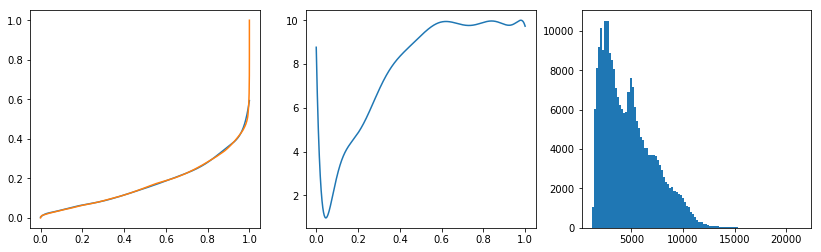

In [54]:
def FFN(TraX, TraY, TesX, TesY, learning_rate, epochs, batch_size, dim, act): 
    fn1 = tf.nn.sigmoid
    fn2 = tf.nn.relu
    def fn3(x):
        return x/(1+np.abs(x))
    ac  = [fn1,fn3,fn1,fn3,fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1] # number of entry = len(dim) - 2
    total_batch = int(len(TraX)/batch_size) + 1
    Xdata = [ TraX[i*batch_size:(i+1)*batch_size] for i in range(total_batch) ]
    Ydata = [ TraY[i*batch_size:(i+1)*batch_size] for i in range(total_batch) ]
    
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, TraX.shape[1]])
    Y = tf.placeholder(tf.float32, [None, TraY.shape[1]])
        
    W = [ tf.Variable(tf.random_normal([dim[i], dim[i+1]])) for i in range(len(dim) - 1) ]
    b = [ tf.Variable(tf.random_normal([dim[i+1]]))         for i in range(len(dim) - 1) ]
    A = [ X ]
    for i in range(len(dim) - 2):
        A.append(ac[i](tf.matmul(A[-1], W[i]) + b[i]))
    A.append(tf.matmul(A[-1], W[-1]) + b[-1])  
    if act == 0:
        cost = tf.sqrt(tf.reduce_mean(tf.reduce_mean(tf.square(Y - A[-1]) ))) 
    if act == 1:
        cost = tf.sqrt(tf.reduce_mean(tf.reduce_mean(tf.square(Y - A[-1])*error_function(Y,label,100,12,1,bpara) ))) 
    gogo = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    real = tf.placeholder(tf.float32, [None, TraY.shape[1]])
    pred = tf.placeholder(tf.float32, [None, TraY.shape[1]])
    rmse = tf.sqrt(tf.reduce_mean(tf.reduce_mean(tf.square(real - pred))))
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):    
        for i in range(total_batch):
            feed1 = {X:Xdata[i], Y:Ydata[i]}
            sess.run(gogo, feed_dict = feed1)
            training_error = sess.run(cost, feed_dict = feed1)
            prediction     = sess.run(A[-1], feed_dict = {X:TesX})
            test_error     = sess.run(rmse, feed_dict = {real:TesY, pred:prediction})
        if epoch % int(epochs/5) == 0:    
            print('Training Error:',training_error,'and','Testing Error:', test_error)
    return prediction


    
def error_function(x, data, bins, degree, Min, Max):
    vec       = ((data - np.min(data,0))/float(np.max(data,0)-np.min(data,0)))
    interval  = [ i/float(bins) for i in range(bins + 1)]
    frequency = np.array([ ((vec<=interval[i+1]).sum() - (vec<interval[i]).sum())/float(len(vec)) for i in range(bins) ])
    xx        = np.arange(bins)/float(bins - 1)
    mat       = np.concatenate([(xx**i).reshape(-1,1) for i in range(degree)], axis=1)
    #print mat
    #print frequency
    coef      = np.dot(np.linalg.inv(np.dot(mat.T,mat)), np.dot(mat.T, frequency))
    poly      = 1 - sum([coef[i]*(x**i) for i in range(degree)])
    values    = 1 - sum([coef[i]*(xx**i) for i in range(degree)])
    M, N      = np.max(values), np.min(values)
    return (Max - Min)/float(M - N)*(poly - N) + Min 
def uniformize(reduction, label):
    mat = np.concatenate([reduction, label], axis=1)
    temporary = []
    for i in range(mat.shape[1]):
        a = np.arange(len(mat)).reshape(-1,1)
        b = np.concatenate([a,mat[:,[i]]], axis=1)
        c = b[b[:,1].argsort()]
        c[:,1] = np.arange(len(mat))/(len(mat)-1)
        d = c[c[:,0].argsort()]
        temporary.append(d[:,1])
    input_data = (np.array(temporary).T)[:, :-1]
    target     = (np.array(temporary).T)[:,[-1]]
    return input_data, target
def rmse(x,y):
    x = x.flatten()
    y = y.flatten()
    return np.sqrt((((x-y))**2).mean())
def Rmse(x,y):
    return np.sqrt( ( ( ((Max-Min)*x+Min).flatten()-((Max-Min)*y+Min).flatten() )**2 ).mean() )
def cc(x,y):
    return np.corrcoef( x.flatten(), y.flatten() )[0,1]
def sort(x):
    return np.sort(x.flatten())
def unit(x):
    return (x-np.min(x,0))/(np.max(x,0)-np.min(x,0))
def f_act(x):
    degree = 12
    y_val = np.sort(unit(label.flatten()))
    X     = (np.arange(len(y_val))/float(len(y_val)-1) )
    mat   = np.concatenate([(X**i).reshape(-1,1) for i in range(degree)], axis=1)
    print X
    print mat
    coef  = np.dot(np.linalg.inv(np.dot(mat.T,mat)), np.dot(mat.T, y_val))
    poly  = sum([coef[i]*(x**i) for i in range(degree)])
    return poly
x = np.arange(100001)/float(100000)
pl.figure(figsize=(14,4))
pl.subplot(131)
pl.plot(x,f_act(x))
pl.plot(np.arange(len(label))/float(len(label)-1),np.sort(unit(label.flatten())))
pl.subplot(132)
pl.plot(x, error_function(x, label, 100, 12, 1, 10))
pl.subplot(133)
_,_,_ = pl.hist(label, 100)

In [55]:
def Figure(Label, Prediction, bins):
    recover_testY = (Max-Min)*Label.flatten()      + Min
    recover_pred  = (Max-Min)*Prediction.flatten() + Min
    pl.figure(figsize=(15,15))
    gs = gridspec.GridSpec(2,2, width_ratios=[1,1], height_ratios=[1,1])
    
    pl.subplot(gs[0,:])
    pl.plot(recover_testY/1000., c='r', label ='Observation')
    pl.plot(recover_pred /1000., c='b', label ='Prediction')
    pl.ylabel('height(km)')
    pl.ylim([0,18])
    pl.legend()
    pl.title('non-storm<=%d b=%d lat=[%.1f, %.1f] samplerate=%.2f'%(nostorm,bpara,latmin, latmax, samplerate))
    print('RMSE:'     , np.round(rmse(Label, Prediction) , 4))
    print('real RMSE:', np.round(Rmse(Label, Prediction) , 4))
    print('CC:'       , np.round(  cc(Label, Prediction) , 4))
    
    pl.subplot(gs[2]) # values prediction and testY are between -4 and 4
    aa = recover_pred
    bb = recover_testY
    interval           = np.array([ Min + (Max - Min)/bins*i for i in range(bins+1) ])
    interval1          = np.array([ Min + (Max - Min)/bins*i for i in range(bins+1) ])
    revised_interval   = interval[:-1]  + (Max - Min)/(2*bins)
    revised_interval1  = interval1[:-1] + (Max - Min)/(2*bins)
    cumulative_number  = []
    cumulative_number1 = []
    for i in range(bins):
        cumulative_number.append(  (aa < interval[i+1] ).sum() - (aa < interval[i] ).sum() )
        cumulative_number1.append( (bb < interval1[i+1]).sum() - (bb < interval1[i]).sum() )
    pl.plot(revised_interval/.1000          , cumulative_number   , color='green', alpha=0.5, label='Prediction')    
    pl.fill_between(revised_interval/.1000  , cumulative_number, 0, color='green', alpha=0.5)
    pl.plot(revised_interval1/.1000         , cumulative_number1  , color='red'  , alpha=0.5 ,label='Observation')    
    pl.fill_between(revised_interval1/.1000 ,cumulative_number1, 0, color='red'  , alpha=0.5)
    pl.ylabel('number of samples')
    pl.xlabel('height(km)')
    pl.legend() 
    pl.title('Distribution')
    pl.legend()

    #*** 2D histogram **********
    H,xbnd,ybnd = np.histogram2d(recover_testY/1000, recover_pred/1000, bins=[np.arange(0,20,0.5), np.arange(0,20,0.5)])
    H = ma.masked_equal(H,0)
    X,Y = np.meshgrid(xbnd,ybnd)
    pl.subplot(gs[3])
    pl.pcolormesh(X,Y,H.T, cmap='jet')
    pl.axis([0,18,0,18])
    pl.xticks([0,5,10,15])
    pl.yticks([0,5,10,15])
    pl.plot([0,35],[0,35],'k')
    pl.xlabel('Observation(km)')
    pl.ylabel('Prediction(km)')
    pl.title('Correlation')
    pl.grid()
    pl.colorbar()
    
    #pl.scatter(recover_testY/1000, recover_pred/1000,s=3)
    #pl.plot(np.arange(18000)/1000,np.arange(18000)/1000,c='black',linestyle = ':')
    #pl.axis([0,18,0,18])
    #pl.xticks([0,5,10,15])
    #pl.yticks([0,5,10,15])
    #pl.xlabel('Observation(km)')
    #pl.ylabel('Prediction(km)')
    #pl.title('Correlation')
    #pl.grid()

In [56]:
# Surface index 1
Type = 1 - 1
print(trainX[Type].shape)
print trainX
print trainX.shape,testX.shape
print trainY.shape,testY.shape

(10,)
[[0.6012128  0.87483096 0.32579833 ... 0.54711163 0.25203452 0.5151447 ]
 [0.6041678  0.877993   0.3197985  ... 0.5454686  0.25019982 0.51744324]
 [0.608352   0.8803806  0.31510243 ... 0.55402863 0.25270435 0.5263969 ]
 ...
 [0.33926898 0.8595308  0.42593735 ... 0.53643596 0.6130622  0.51718843]
 [0.3381572  0.8589311  0.42796278 ... 0.53076065 0.606998   0.5173563 ]
 [0.34654832 0.8659591  0.40918043 ... 0.52565193 0.60506743 0.51710314]]
(136028, 10) (58298, 10)
(136028, 1) (58298, 1)


In [60]:
bpara = 10
# Apply error function
#Train, Label = unit(reduction), unit(label)
#ntrain       = int(0.7*len(reduction))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)
#dim = [trainX.shape[2], 30, 30, 30,10, trainY.shape[1]]
dim = [trainX.shape[1], 30, 30, 30,10, trainY.shape[1]]
prediction   = FFN(trainX, trainY, testX, testY, 0.005, 50, 1024*4, dim, 1)
#prediction   = FFN(trainX, trainY, testX, testY, 0.005, 50, 1024*4, dim, 0)

((136028, 10), (136028, 1), (58298, 10), (58298, 1))
('Training Error:', 0.23070355, 'and', 'Testing Error:', 0.10159165)
('Training Error:', 0.13289759, 'and', 'Testing Error:', 0.063591056)
('Training Error:', 0.13006438, 'and', 'Testing Error:', 0.06233631)
('Training Error:', 0.1293563, 'and', 'Testing Error:', 0.06177209)
('Training Error:', 0.12891576, 'and', 'Testing Error:', 0.06150193)


('RMSE:', 0.0614)
('real RMSE:', 1239.6022)
('CC:', 0.84)


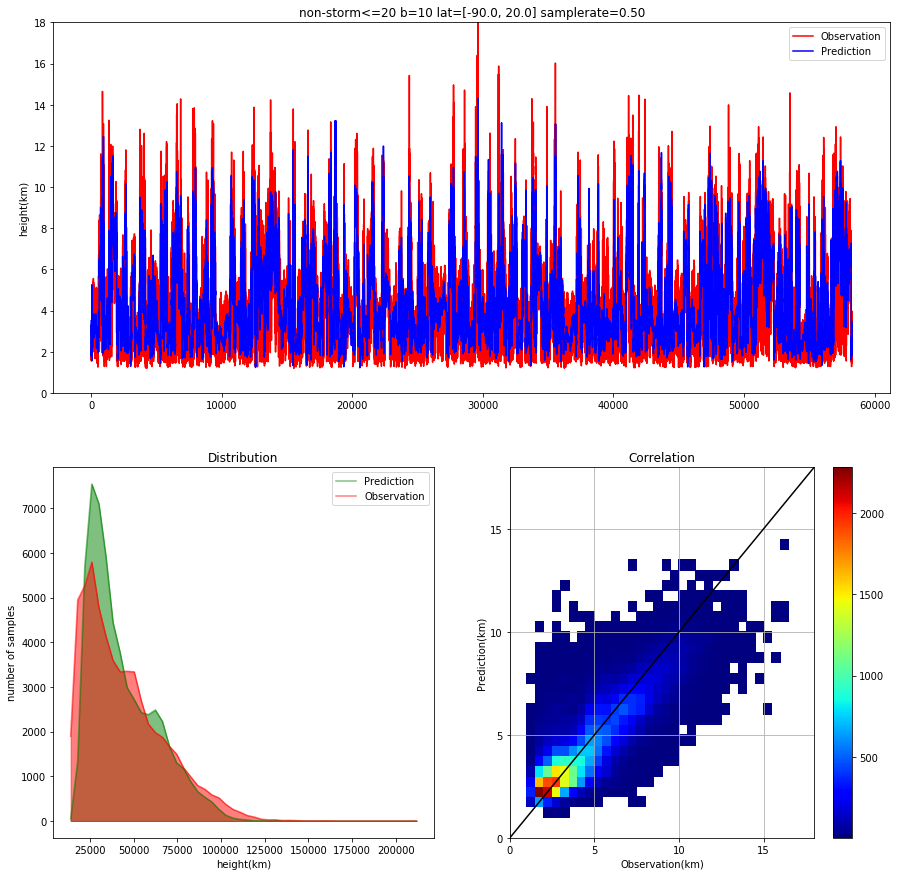

In [61]:
Figure(testY, prediction, 50)